In [1]:
using Distributed
addprocs(6-nprocs())  # Adjust the number to match the number of CPU threads (logical cores)
println("# workers = ", nprocs())

# workers = 6


In [2]:
@everywhere include("higherHallCrystals.jl")
@everywhere using LinearAlgebra, Plots, .higherHall, Measures, JLD2, Colors, LaTeXStrings

We plot a quick, low-res version of the phase diagram below. Resolution is set by `N_nu` and `N_am`. When they are set to 40, this takes about 3 minutes with 6 CPU cores. 

In [ ]:
# Dispersion
x = range(0.0, 1, length=10^5)
y = cos.(2π*x)  # make sure it's periodic w/ period 1

N = 150  # total number of unit cells in system (# wires = 2N)
lB = 1.0  # magnetic length
λ = 1.0  # scr. length 
inversion_symmetric = true
g₀ = 0.05  # sets interaction strength, just need it small enough
d = 40 # max support of cosine operators
n = 5 # how many lowest operators to keep

# For plotting 
N_nu = 40
N_am = 40
@assert N_nu == N_am # need this for process_chunks to work 
nu_vec = LinRange(0.1, 0.9, N_nu)
log_am_vec = LinRange(log2(0.33), log2(5.0), N_am)
am_vec = 2 .^ log_am_vec

U_max = find_maxU(x,y,minimum(nu_vec),maximum(nu_vec),minimum(am_vec),maximum(am_vec),10,lB,λ)
println("Umax = ", U_max)
chern_mat = Array{Vector{Int}, 2}(undef, N_am, N_nu)
scdim_mat = Array{Vector{Float64}, 2}(undef, N_am, N_nu)
op_mat = Array{Vector{Vector{Int64}}, 2}(undef, N_am, N_nu)
param_grid = [(nu, aₘ) for nu in nu_vec, aₘ in am_vec];# Create the parameter grid
function create_chunks(param_grid, chunk_size)
    chunks = [param_grid[i:min(i+chunk_size-1, end)] for i in 1:chunk_size:length(param_grid)]
    return chunks
end

chunk_size = 2000  # Adjust chunk size based on your specific requirements
chunks = create_chunks(param_grid, chunk_size)
println("numChunks = ",length(chunks))

@everywhere function process_chunk(chunk, x, y, lB, λ, inversion_symmetric, N, g₀,U_max, d, n)
    results = Vector{Tuple{Vector{Float64}, Vector{Vector{Int64}}, Vector{Int64}}}(undef, length(chunk))
    for (i, param) in enumerate(chunk)
        nu, aₘ = param
        results[i] = leading_instabilities(x, y, nu, aₘ, lB, λ, inversion_symmetric, N, g₀, U_max, d, n)
    end
    println("Chunk completed, aₘ = ",chunk[end][end])
    return results
end
@time begin
    chunk_results = pmap(chunk -> process_chunk(chunk, x, y, lB, λ, inversion_symmetric, N, g₀, U_max,d, n), chunks)
end
results = [res for chunk_res in chunk_results for res in chunk_res]
# Reshape the results into matrices
for idx in 1:length(results)
    i = (idx - 1) % N_am + 1
    j = (idx - 1) ÷ N_am + 1
    scdim_mat[i, j], op_mat[i, j], chern_mat[i, j]= results[idx]
end
scdim0 = [scdim_mat[i, j][1] for i in 1:N_am, j in 1:N_nu]; chern0 = [chern_mat[i, j][1] for i in 1:N_am, j in 1:N_nu]; op0 = [op_mat[i, j][1] for i in 1:N_am, j in 1:N_nu];

Umax = 0.6585384614318133
numChunks = 1
      From worker 2:	Chunk completed, aₘ = 4.999999999999999
125.046835 seconds (2.35 M allocations: 121.432 MiB, 0.03% gc time, 0.54% compilation time)


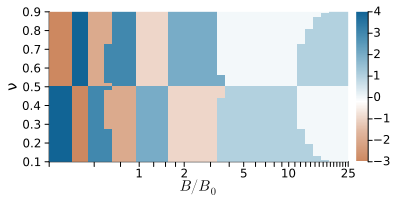

In [4]:
# Plotting
# Adjustable parameters
xlabel_size = 10
ylabel_size = 10
ticklabel_size = 8
title_size = 14
xtick_positions =vcat(0.25:0.25:1.75,2:1:25)
xtick_labels = ["","","","1","","","","2","","","5","","","","","10","","","","","","","","","","","","","","","25"]
ytick_values = 0:0.1:1

size_xy = [400, 200]
title_var = λ  # variable in title
off_set = 3  # tunes the color palette

# Vector of Chern numbers
chern_vec = unique(chern0)

# Generate phase_labels from chern_vec
phase_labels = ["C=$(v)" for v in sort(chern_vec)]

# Define the color theme using the :vik50 gradient
color_theme = palette(:vik, 2000)
phase_colors = vcat(color_theme[1400],color_theme[1200],RGB{Float64}(1.0,1.0,1.0),color_theme[800],color_theme[600],color_theme[400])


# Create the heatmap with customized font sizes and tick values
p=heatmap(am_vec.^2, nu_vec, chern0,
    color=phase_colors,
    size=size_xy,
    xaxis=:log2,
    xlabel=L"B/B_0",
    ylabel="ν",
    xlim=[0.25,maximum(am_vec.^2)],
    ylim=[minimum(nu_vec), maximum(nu_vec)],
    colorbar=true,
    xlabelfontsize=xlabel_size,
    ylabelfontsize=ylabel_size,
    xtickfontsize=ticklabel_size,
    ytickfontsize=ticklabel_size,
    titlefontsize=title_size,
    yticks=ytick_values,
    xticks=(xtick_positions, xtick_labels),
    tick_direction=:out,
    grid = false,
    bottom_margin=1.5mm,
    axesfont=font(20,"Times New Roman")
)
# Display the plot
display(current())  # To explicitly display the plot in some environments

Figure 3b was generated with `N_nu`, `N_am` = 400, which took about six hours. We saved the resulting data in `λ=1.0_N=150_d=40.jld2`, and load and plot it here. 

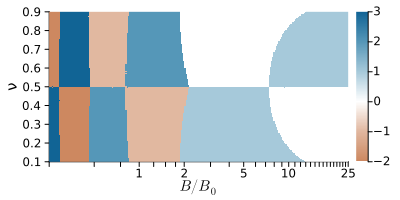

In [3]:

# Load data
data =load_object("datasaves/λ=1.0_N=150_d=40.jld2")
λ = 1.0
N=150
d=40
am_vec = data[2]
nu_vec = data[4]
chern_mat = data[6]
scdim_mat = data[8]
op_mat = data[10]
N_nu = length(nu_vec)
N_am = length(am_vec)
scdim0 = [scdim_mat[i, j][1] for i in 1:N_am, j in 1:N_nu]; chern0 = [chern_mat[i, j][1] for i in 1:N_am, j in 1:N_nu]; op0 = [op_mat[i, j][1] for i in 1:N_am, j in 1:N_nu];


# Plotting
# Adjustable parameters
xlabel_size = 10
ylabel_size = 10
ticklabel_size = 8
title_size = 14
xtick_positions =vcat(0.25:0.25:1.75,2:1:25)
xtick_labels = ["","","","1","","","","2","","","5","","","","","10","","","","","","","","","","","","","","","25"]
ytick_values = 0:0.1:1

size_xy = [400, 200]
title_var = λ  # variable in title
off_set = 3  # tunes the color palette

# Vector of Chern numbers
chern_vec = unique(chern0)

# Generate phase_labels from chern_vec
phase_labels = ["C=$(v)" for v in sort(chern_vec)]

# Define the color theme using the :vik50 gradient
color_theme = palette(:vik, 2000)
phase_colors = vcat(color_theme[1400],color_theme[1200],RGB{Float64}(1.0,1.0,1.0),color_theme[800],color_theme[600],color_theme[400])

# few pixels differ from the majority of their nearest-neighbors, since our phase diagram has tolerance >> 1 pixel width
# we correct these, affecting only 12 out of 62500 pixels
chern0v2 = fix_pixels(chern0);
fixed_count = count(!iszero, chern0v2 .- chern0)
total_count = prod(size(chern0v2))

# Create the heatmap with customized font sizes and tick values
p=heatmap(am_vec.^2, nu_vec, chern0v2,
    color=phase_colors,
    size=size_xy,
    xaxis=:log2,
    xlabel=L"B/B_0",
    ylabel="ν",
    xlim=[0.25,maximum(am_vec.^2)],
    ylim=[minimum(nu_vec), maximum(nu_vec)],
    colorbar=true,
    xlabelfontsize=xlabel_size,
    ylabelfontsize=ylabel_size,
    xtickfontsize=ticklabel_size,
    ytickfontsize=ticklabel_size,
    titlefontsize=title_size,
    yticks=ytick_values,
    xticks=(xtick_positions, xtick_labels),
    tick_direction=:out,
    grid = false,
    bottom_margin=1.5mm,
    axesfont=font(20,"Times New Roman")
)
# Display the plot
display(current())  